In [ ]:
# Plot All Energy Components per Mutation

version='FoldX_5.0',
packages=find_packages(),
install_requires=['numpy', 'pandas', 'matplotlib'],
author='Surabhi Rathore',
description='Pipeline for analyzing Nsp8 mutation energetics'


This notebook will:

1. Read each `Dif_<structure>_Repair.fxout` file in the four folders (`7jlt`, `2ahm`, `7bv1`, `6yyt`).
2. Automatically discover all energy terms.
3. For each mutation (Repair group) in each structure, plot **all** replicate bars for those energy terms.
4. Calculates & plots average plot for each mutation across conformations.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


ROOT = Path("20_models_FoldX/")
STRUCTURES = {
    "7jlt": ROOT/"7jlt"/"Dif_7jlt_Repair.fxout",
    "2ahm": ROOT/"2ahm"/"Dif_2ahm_Repair.fxout",
    "7bv1": ROOT/"7bv1"/"Dif_7bv1_Repair.fxout",
    "6yyt": ROOT/"6yyt"/"Dif_6yyt_Repair.fxout",
}

MUT_MAP = {
    "7jlt": {
         1:"CB114A",  2:"CD114A",  3:"CB114A,CD114A",
         4:"CB114Y",  5:"CD114Y",  6:"CB114Y,CD114Y",
         7:"CB114R",  8:"CD114R",  9:"CB114R,CD114R",
        10:"CB114S", 11:"CD114S", 12:"CB114S,CD114S",
    },
    "2ahm": { i:name for i,name in enumerate([
        "CE114A","CF114A","CG114A","CH114A","CEH114A",
        "CE114Y","CF114Y","CG114Y","CH114Y","CEH114Y",
        "CE114R","CF114R","CG114R","CH114R","CEH114R",
        "CE114S","CF114S","CG114S","CH114S","CEH114S",
    ], start=1)},
    "7bv1": {
         1:"CB114A",  2:"CD114A",  3:"CB114A,CD114A",
         4:"CB114Y",  5:"CD114Y",  6:"CB114Y,CD114Y",
         7:"CB114R",  8:"CD114R",  9:"CB114R,CD114R",
        10:"CB114S", 11:"CD114S", 12:"CB114S,CD114S",
    },
    "6yyt": {
         1:"CB114A",  2:"CD114A",  3:"CB114A,CD114A",
         4:"CB114Y",  5:"CD114Y",  6:"CB114Y,CD114Y",
         7:"CB114R",  8:"CD114R",  9:"CB114R,CD114R",
        10:"CB114S", 11:"CD114S", 12:"CB114S,CD114S",
    },
}


In [2]:
def read_fxout(path: Path) -> pd.DataFrame:
    """
    Load a FoldX .fxout (tab-delim, skip 8 header lines) into a DataFrame.
    Drops empty columns automatically.
    """
    df = pd.read_csv(path, sep="\t", skiprows=8, engine="python")
    return df.loc[:, df.columns.notna()]

# Quick test:
for struct, fx in STRUCTURES.items():
    if not fx.exists():
        print(f" Missing {fx}") 
    else:
        print(f"{struct}: {len(read_fxout(fx))} rows")


7jlt: 255 rows
2ahm: 400 rows
7bv1: 255 rows
6yyt: 180 rows


In [ ]:
for struct, fxpath in STRUCTURES.items():
    if not fxpath.exists():
        continue
    df = read_fxout(fxpath)
    
    # Energy terms are all columns after "Pdb"
    energy_terms = list(df.columns)[1:]
    
    # Extract _Repair_ & replicate indices
    base = struct + "_Repair_"
    df["RepairIdx"]    = df["Pdb"].str.extract(fr"{base}(\d+)_\d+")[0].astype(int)
    df["ReplicateIdx"] = df["Pdb"].str.extract(fr"{base}\d+_(\d+)")[0].astype(int)
    
    # plot one per Repair group
    for ridx, label in MUT_MAP[struct].items():
        sub = df[df["RepairIdx"] == ridx].sort_values("ReplicateIdx")
        if sub.empty: 
            continue
        
        nrep = len(sub)
        x = np.arange(len(energy_terms))
        width = 0.8 / nrep
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, nrep))
        
        fig, ax = plt.subplots(figsize=(12,5))
        for i, row in sub.iterrows():
            vals = row[energy_terms].astype(float).values
            ax.bar(
                x + (row["ReplicateIdx"] - (nrep-1)/2)*width,
                vals, width,
                label=f"run {int(row['ReplicateIdx'])}",
                color=colors[int(row["ReplicateIdx"])],
                edgecolor='k'
            )
        
        ax.set_xticks(x)
        ax.set_xticklabels(energy_terms, rotation=30, ha="right")
        ax.set_ylabel("Energy (kcal·mol⁻¹)")
        ax.set_title(f"{struct.upper()} – {label} (Repair {ridx})")
        ax.axhline(0, color='gray', lw=0.7)
        ax.legend(ncol=3, bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
        plt.tight_layout()
        
        out = f"{struct}_Repair{ridx}_{label.replace(',','_')}.png"
        fig.savefig(out, dpi=300)
        plt.close(fig)
        print(f"Wrote {out}")

In [ ]:
#Plot for average and SE across models

In [3]:
import re, math

In [4]:
#Compute means & SEM and save CSV


ROOT = Path("20_models_FoldX/")
STRUCTURES = {
    "7jlt": "Dif_7jlt_Repair.fxout",
    "2ahm": "Dif_2ahm_Repair.fxout",
    "7bv1": "Dif_7bv1_Repair.fxout",
    "6yyt": "Dif_6yyt_Repair.fxout",
}

# For each structure, which single RepairIdx corresponds to each mutation type:
REPAIR_FOR_MUT = {
    "7jlt": {"C114A":  3, "C114Y":  6, "C114R":  9, "C114S": 12},
    "2ahm": {"C114A":  5, "C114Y": 10, "C114R": 15, "C114S": 20},
    "7bv1": {"C114A":  3, "C114Y":  6, "C114R":  9, "C114S": 12},
    "6yyt": {"C114A":  3, "C114Y":  6, "C114R":  9, "C114S": 12},
}

TERM = "total energy"

def read_fxout(path):
    df = pd.read_csv(path, sep="\t", skiprows=8, engine="python")
    return df.loc[:, df.columns.notna()]

rows = []
for struct, fname in STRUCTURES.items():
    fx = ROOT/struct/fname
    df = read_fxout(fx)
    # extract the FoldX Repair index
    pat = re.compile(fr"{struct}_Repair_(\d+)_\d+\.pdb")
    df["RepairIdx"] = df["Pdb"].str.extract(pat).astype(int)

    for mut, ridx in REPAIR_FOR_MUT[struct].items():
        # take all replicates of exactly that RepairIdx
        subset = df[df["RepairIdx"] == ridx][TERM]
        n = len(subset)
        mean = subset.mean()
        sem  = subset.std(ddof=1)/math.sqrt(n) if n>1 else 0.0
        rows.append({
            "Structure": struct,
            "Mutation":  mut,
            "Mean":       mean,
            "SEM":        sem
        })

summary = pd.DataFrame(rows)
summary.to_csv("20_models_FoldX/Total_energy_mutation_summary.csv", index=False)
summary


,Structure,Mutation,Mean,SEM
0,7jlt,C114A,1.629980,0.002833
1,7jlt,C114Y,21.339270,0.380831
2,7jlt,C114R,8.067051,0.405578
3,7jlt,C114S,2.629339,0.033183
4,2ahm,C114A,3.671955,0.011409
5,2ahm,C114Y,21.559660,0.681279
6,2ahm,C114R,15.842015,0.780920
7,2ahm,C114S,6.732780,0.024968
8,7bv1,C114A,0.646410,0.000260
9,7bv1,C114Y,13.254206,0.878575


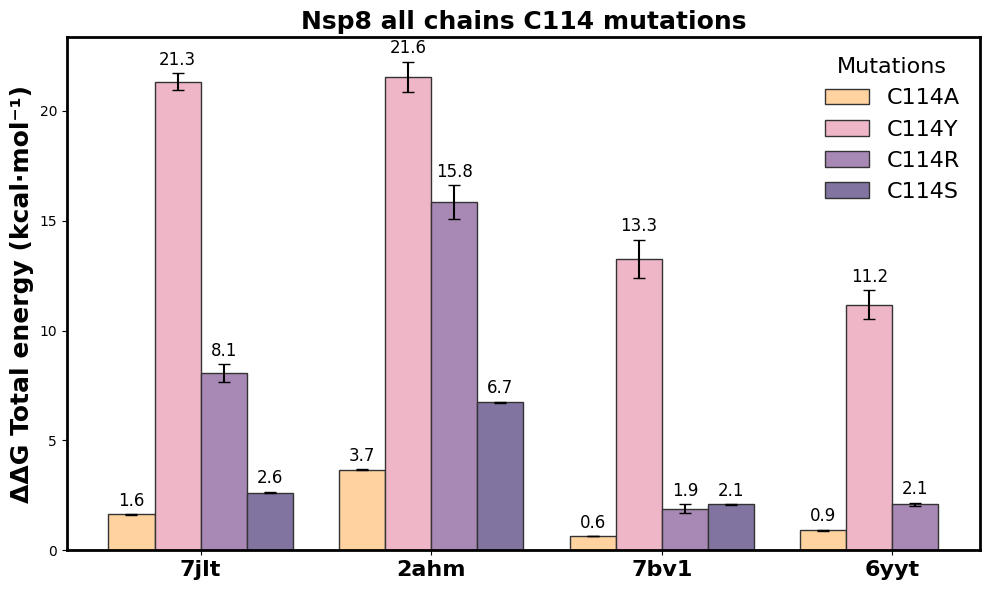

In [5]:

# reload your summary DataFrame
# summary = pd.read_csv("20_models_FoldX/Total_energy_mutation_summary.csv")

structures = ["7jlt","2ahm","7bv1","6yyt"]
mutations  = ["C114A","C114Y","C114R","C114S"]
colors     = {
    "C114A": "#FFD2A0",   
    "C114Y": "#EFB6C8",   
    "C114R": "#A888B5",   
    "C114S": "#8174A0",  
}

# pivot out means & sems
means = summary.pivot(index="Structure", columns="Mutation", values="Mean").loc[structures]
sems  = summary.pivot(index="Structure", columns="Mutation", values="SEM").loc[structures]

x     = np.arange(len(structures))
n_mut = len(mutations)
width = 0.8 / n_mut

fig, ax = plt.subplots(figsize=(10, 6))

# plot bars
for i, mut in enumerate(mutations):
    ax.bar(
        x + (i - (n_mut-1)/2)*width,
        means[mut],
        width,
        yerr=sems[mut],
        capsize=4,
        label=mut,
        color=colors[mut],
        edgecolor="#333333",
        linewidth=1.0
    )

# thick plot outline
for spine in ax.spines.values():
    spine.set_linewidth(2)

# ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(structures, fontsize=16, fontweight="bold")
ax.set_ylabel("ΔΔG Total energy (kcal·mol⁻¹)", fontsize=18, fontweight="bold")
ax.set_title("Nsp8 all chains C114 mutations", fontsize=18, fontweight="bold")

# horizontal zero line
ax.axhline(0, color="gray", linewidth=1)

# legend with bigger font
ax.legend(title="Mutations", frameon=False, fontsize=16, title_fontsize=16, loc="upper right")

# annotate above error bars
for i, struct in enumerate(structures):
    for j, mut in enumerate(mutations):
        m = means.loc[struct, mut]
        e = sems.loc[struct, mut]
        # place label just above the top of the error bar
        y = m + e + 0.2 if m >= 0 else m - e - 0.2
        ax.text(
            x[i] + (j - (n_mut-1)/2)*width,
            y,
            f"{m:.1f}",
            ha="center",
            va="bottom" if m>=0 else "top",
            fontsize=12,
            fontweight="medium"
        )

plt.tight_layout()
plt.show()
